Enter the coordinate limit (e.g., 200):  200
Enter the number of clusters (e.g., 8):  8
Enter the total number of nodes (e.g., 500):  89


Generated 88 total nodes
Nodes per cluster: 11

Coordinate ranges for each cluster:
Cluster 1:
  X-range: [0.5, 23.2]
  Y-range: [17.9, 181.0]
Cluster 2:
  X-range: [25.9, 45.7]
  Y-range: [18.8, 176.8]
Cluster 3:
  X-range: [55.0, 72.4]
  Y-range: [20.5, 198.2]
Cluster 4:
  X-range: [78.5, 99.9]
  Y-range: [15.6, 183.9]
Cluster 5:
  X-range: [101.3, 124.1]
  Y-range: [3.5, 177.0]
Cluster 6:
  X-range: [126.1, 148.6]
  Y-range: [0.8, 186.5]
Cluster 7:
  X-range: [150.3, 173.5]
  Y-range: [1.6, 199.5]
Cluster 8:
  X-range: [178.0, 199.9]
  Y-range: [10.0, 199.5]


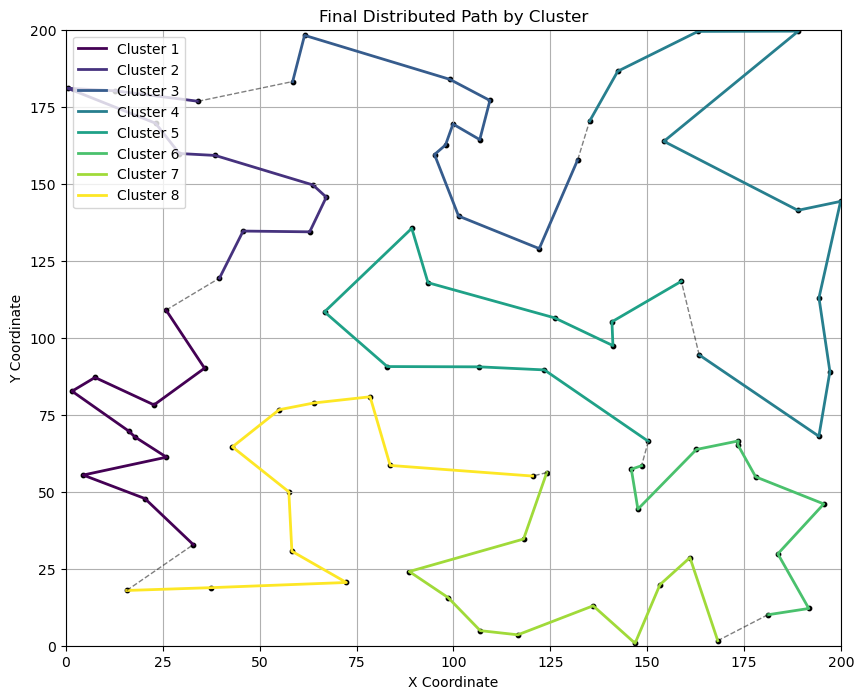

In [37]:
import matplotlib.pyplot as plt
import numpy as np
from math import ceil
from python_tsp.heuristics import solve_tsp_simulated_annealing
from scipy.spatial.distance import pdist, squareform

class DistributedClusterTSPSolver:
    def __init__(self, coordinate_limit, num_clusters, total_nodes):
        self.coordinate_limit = coordinate_limit
        self.num_clusters = num_clusters
        self.total_nodes = total_nodes
        self.cluster_coordinates = None
        self.full_coordinates = None
        self.cluster_paths = None
        self.final_distributed_path = None
    
    def generate_cluster_nodes(self):
        """Generate nodes distributed across distinct clusters"""
        self.cluster_coordinates = np.empty((0, 2), float)
        
        # Calculate nodes per cluster
        nodes_per_cluster = max(1, self.total_nodes // self.num_clusters)
        
        # Generate coordinates for each cluster in distinct regions
        for i in range(self.num_clusters):
            x = np.random.uniform(i * self.coordinate_limit/self.num_clusters, 
                                (i+1) * self.coordinate_limit/self.num_clusters,
                                size=(nodes_per_cluster, 1))
            y = np.random.uniform(0, self.coordinate_limit, 
                                size=(nodes_per_cluster, 1))
            section_coords = np.column_stack((x, y))
            self.cluster_coordinates = np.append(self.cluster_coordinates, section_coords, axis=0)
        
        # Print verification information
        print(f"Generated {len(self.cluster_coordinates)} total nodes")
        print(f"Nodes per cluster: {nodes_per_cluster}")
        print("\nCoordinate ranges for each cluster:")
        for i in range(self.num_clusters):
            start = i * nodes_per_cluster
            end = (i + 1) * nodes_per_cluster
            print(f"Cluster {i+1}:")
            print(f"  X-range: [{self.cluster_coordinates[start:end, 0].min():.1f}, {self.cluster_coordinates[start:end, 0].max():.1f}]")
            print(f"  Y-range: [{self.cluster_coordinates[start:end, 1].min():.1f}, {self.cluster_coordinates[start:end, 1].max():.1f}]")
        
        return self.cluster_coordinates
    
    def plot_distributed_path(self):
        """Plot the final distributed path showing cluster sections"""
        plt.figure(figsize=(10, 8))
        colors = plt.cm.viridis(np.linspace(0, 1, self.num_clusters))
        points_per_cluster = len(self.final_distributed_path) // self.num_clusters
        
        for i in range(self.num_clusters):
            start_idx = i * points_per_cluster
            end_idx = start_idx + points_per_cluster if i < self.num_clusters - 1 else len(self.final_distributed_path)
            
            plt.plot(self.final_distributed_path[start_idx:end_idx, 0],
                    self.final_distributed_path[start_idx:end_idx, 1],
                    color=colors[i],
                    linewidth=2,
                    label=f'Cluster {i+1}')
            
            if i < self.num_clusters - 1:
                next_start_idx = (i + 1) * points_per_cluster
                plt.plot([self.final_distributed_path[end_idx-1, 0], self.final_distributed_path[next_start_idx, 0]],
                        [self.final_distributed_path[end_idx-1, 1], self.final_distributed_path[next_start_idx, 1]],
                        'k--',
                        linewidth=1,
                        alpha=0.5)
        
        plt.plot([self.final_distributed_path[-1, 0], self.final_distributed_path[0, 0]],
                [self.final_distributed_path[-1, 1], self.final_distributed_path[0, 1]],
                'k--',
                linewidth=1,
                alpha=0.5)
        
        plt.scatter(self.cluster_coordinates[:, 0], self.cluster_coordinates[:, 1],
                    color='black', s=10)
        plt.title('Final Distributed Path by Cluster')
        plt.xlabel('X Coordinate')
        plt.ylabel('Y Coordinate')
        plt.xlim(0, self.coordinate_limit)
        plt.ylim(0, self.coordinate_limit)
        plt.legend(loc='upper left')
        plt.grid(True)
        plt.show()
    
    def optimize_final_path_with_cluster_edges(self):
        """Optimize the final path while preserving cluster connections"""
        edges = set()
        for path in self.cluster_paths:
            for i in range(len(path) - 1):
                edges.add((tuple(path[i]), tuple(path[i + 1])))
        
        nodes = set()
        for edge in edges:
            nodes.update(edge)
        nodes = list(nodes)
        node_index = {node: idx for idx, node in enumerate(nodes)}
        num_nodes = len(nodes)
        distance_matrix = np.full((num_nodes, num_nodes), np.inf)
        
        for edge in edges:
            i = node_index[edge[0]]
            j = node_index[edge[1]]
            dist = np.linalg.norm(np.array(edge[0]) - np.array(edge[1]))
            distance_matrix[i, j] = dist
            distance_matrix[j, i] = dist
        
        for i in range(num_nodes):
            for j in range(i + 1, num_nodes):
                if distance_matrix[i, j] == np.inf:
                    dist = np.linalg.norm(np.array(nodes[i]) - np.array(nodes[j]))
                    distance_matrix[i, j] = dist
                    distance_matrix[j, i] = dist
        
        permutation, _ = solve_tsp_simulated_annealing(distance_matrix)
        self.final_distributed_path = np.array(nodes)[permutation]
        
        points_per_cluster = len(self.final_distributed_path) // self.num_clusters
        for i in range(self.num_clusters-1):
            section_start = i * points_per_cluster
            section_end = (i + 1) * points_per_cluster
            current_last = self.final_distributed_path[section_end-1]
            next_first = self.final_distributed_path[section_end]
            
            if np.linalg.norm(current_last - next_first) > np.mean(distance_matrix):
                next_section = self.final_distributed_path[section_end:section_end+points_per_cluster]
                distances = [np.linalg.norm(current_last - p) for p in next_section]
                closest_idx = np.argmin(distances)
                self.final_distributed_path[section_end:section_end+points_per_cluster] = \
                    np.roll(next_section, -closest_idx, axis=0)
        
        return self.final_distributed_path
    
    def optimize_cluster_paths(self):
        """Optimize paths within each cluster"""
        self.full_coordinates = np.array_split(self.cluster_coordinates, self.num_clusters)
        self.cluster_paths = []
        for coords in self.full_coordinates:
            distance_matrix = squareform(pdist(coords, metric='euclidean'))
            permutation, _ = solve_tsp_simulated_annealing(distance_matrix)
            self.cluster_paths.append(coords[permutation])
        return self.cluster_paths
    
    def solve(self):
        """Main method to solve the distributed cluster TSP"""
        self.generate_cluster_nodes()
        self.optimize_cluster_paths()
        self.optimize_final_path_with_cluster_edges()
        self.plot_distributed_path()

if __name__ == '__main__':
    coordinate_limit = int(input("Enter the coordinate limit (e.g., 200): "))
    num_clusters = int(input("Enter the number of clusters (e.g., 8): "))
    total_nodes = int(input("Enter the total number of nodes (e.g., 500): "))
    
    solver = DistributedClusterTSPSolver(coordinate_limit, num_clusters, total_nodes)
    solver.solve()